In [1]:
import cv2
import numpy as np
import os
import pandas as pd
from random import shuffle
from tqdm import tqdm
from tensorflow.python.framework import ops
import csv
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPooling2D
import matplotlib.pyplot as plt

from tensorboard.backend.event_processing import event_accumulator
# from tflearn.layers.conv import  conv_2d, max_pool_2d
# from tflearn.layers.core import input_data, dropout, fully_connected
# from tflearn.layers.estimator import regression
from pickle import dump
from pickle import load
from sklearn.model_selection import train_test_split
# import tflearn
from keras import applications
import keras as ks
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,BatchNormalization
# from tflearn.utils import string
import pickle as pk
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q kaggle
!pip install datasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d coder98/emotionpainx

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [5]:
!mkdir 

mkdir: missing operand
Try 'mkdir --help' for more information.


In [6]:
!unzip emotionpain.zip -d /content/drive/MyDrive

unzip:  cannot find or open emotionpain.zip, emotionpain.zip.zip or emotionpain.zip.ZIP.


# Fine-Tuning Vision Transformers for Image Classification

Just as transformers-based models have revolutionized NLP, we're now seeing an explosion of papers applying them to all sorts of other domains. One of the most revolutionary of these was the Vision Transformer (ViT), which was introduced in [June 2021](https://arxiv.org/abs/2010.11929) by a team of researchers at Google Brain.

This paper explored how you can tokenize images, just as you would tokenize sentences, so that they can be passed to transformer models for training. Its quite a simple concept, really...

1. Split an image into a grid of sub-image patches
1. Embed each patch with a linear projection
1. Each embedded patch becomes a token, and the resulting sequence of embedded patches is the sequence you pass to the model.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)


It turns out that once you've done the above, you can pre-train and finetune transformers just as you're used to with NLP tasks. Pretty sweet 😎.

---

In this notebook, we'll walk through how to leverage 🤗 `datasets` to download and process image classification datasets, and then use them to fine-tune a pre-trained ViT with 🤗 `transformers`. 

To get started, lets first install both those packages.

In [7]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers

## Load a dataset

# Let's start by loading a small image classification dataset and taking a look at its structure.

We'll use the [`beans`](https://huggingface.co/datasets/beans) dataset, which is a collection of pictures of healthy and unhealthy bean leaves. 🍃



Let's take a look at the 400th example from the `'train'` split from the beans dataset. You'll notice each example from the dataset has 3 features:

1. `image`: A PIL Image
1. `image_file_path`: The `str` path to the image file that was loaded as `image`
1. `labels`: A [`datasets.ClassLabel`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel) feature, which we'll see as an integer representation of the label for a given example. (Later we'll see how to get the string class names, don't worry)

In [8]:
from datasets import Features, ClassLabel


#loading

In [9]:
import os
def create_train_data(TRAIN_DIR,Label_Dir,IMG_SIZE):
    training_data = []
    label_data=[]

    c0=0
    c1=0
    res=0
    #reading label only 
    for folder in os.listdir(Label_Dir):
        c0=0
        for inner_folder in os.listdir((Label_Dir+'/'+folder)):
            path = os.path.join(Label_Dir,folder+'/'+ inner_folder)
            for file in os.listdir(path):
                
                file=os.path.join(path+'/'+file)
                with open(file) as f:
                    lines = f.readlines()
                    if (lines[0][3]=='0' and c0<340):
                      label_data.append('0')
                      res+=1
                      c0+=1
                    if(lines[0][3]!='0'):
                      label_data.append('1')
                      c1+=1
                    f.close()
    print('c0',c0)
    print('c1',c1)
    label_data.append('-1')
    print(str(res) + ' ' + str(c1))
    #reading images and it's labels
    c=0
    c0=0
    c1=0
    res=0
    print(len(label_data))
    for folder in os.listdir(TRAIN_DIR):
        c0=0
        for inner_folder in os.listdir((TRAIN_DIR+'/'+folder)):
            path = os.path.join(TRAIN_DIR,folder+'/'+ inner_folder)
            for img in tqdm(os.listdir(path)):
                img=os.path.join(path+'/'+img)
                img_data = cv2.imread(img,cv2.IMREAD_COLOR)#cv2.IMREAD_COLOR
                img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
                img_data = cv2.cvtColor(img_data,cv2.COLOR_RGB2BGR)
                if (label_data[c]=='-1'):break
                if (label_data[c]=='0' and c0<340):
                  training_data.append([np.array(img_data), label_data[c]])
                  c0+=1
                  res+=1
                  c+=1
                if (label_data[c]!='0'):
                  training_data.append([np.array(img_data), label_data[c]])
                  c+=1
                  c1+=1
            #print(str(res) + ' ' + str(c1))      

    print(str(res) + ' ' + str(c1))           

    shuffle(training_data) 
    dump(training_data, open('/content/drive/MyDrive/training_data.pkl', 'wb'))
    return training_data

In [10]:
#train_data=create_train_data('/content/drive/MyDrive/images/Images','/content/drive/MyDrive/Frame_Labels/Frame_Labels/PSPI',200)

In [11]:
# if (os.path.exists('/content/drive/MyDrive/training_data.pkl')):
#     training_data = load(open('/content/drive/MyDrive/training_data.pkl', 'rb'))
# ImgSize = 200
# train = training_data
# X_train = np.array([i[0] for i in train]).reshape(-1, ImgSize, ImgSize, 3)
# y_train = [i[1] for i in train]

# X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
# y_train_one_hot = to_categorical(y_train1)
# y_test_one_hot = to_categorical(y_test1)

In [51]:
if (os.path.exists('/content/drive/MyDrive/x_train_new.pkl')):
    X_train = load(open('/content/drive/MyDrive/x_train_new.pkl', 'rb'))
if (os.path.exists('/content/drive/MyDrive/y_train_new.pkl')):
    y_train = load(open('/content/drive/MyDrive/y_train_new.pkl', 'rb'))
if (os.path.exists('/content/drive/MyDrive/x_val_new.pkl')):
    x_val = load(open('/content/drive/MyDrive/x_val_new.pkl', 'rb'))
if (os.path.exists('/content/drive/MyDrive/y_val_new.pkl')):
    y_val = load(open('/content/drive/MyDrive/y_val_new.pkl', 'rb'))
if (os.path.exists('/content/drive/MyDrive/x_test_new.pkl')):
    x_test = load(open('/content/drive/MyDrive/x_test_new.pkl', 'rb'))
if (os.path.exists('/content/drive/MyDrive/y_test_new.pkl')):
    y_test = load(open('/content/drive/MyDrive/y_test_new.pkl', 'rb'))


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from PIL import Image
pil_images = []
pil_images1 = []
pil_images2 = []
for i in range(X_train.shape[0]):
  im = Image.fromarray(np.uint8(X_train[i]))
  pil_images.append(im)
for i in range(x_val.shape[0]):
  im = Image.fromarray(np.uint8(x_val[i]))
  pil_images1.append(im)
for i in range(x_test.shape[0]):
  im = Image.fromarray(np.uint8(x_test[i]))
  pil_images2.append(im)

In [55]:
x_train_df = pd.DataFrame(data = pil_images)
y_train_df = pd.DataFrame(data = y_train)
x_val_df = pd.DataFrame(data = pil_images1)
y_val_df = pd.DataFrame(data = y_val)
x_test_df = pd.DataFrame(data = pil_images2)
y_test_df = pd.DataFrame(data = y_test)


In [15]:
lst = list()
lst.append("image")
#lst.append("labels")
lst

['image']

In [56]:
x_train_df.set_axis(lst,axis=1, inplace=True)
x_test_df.set_axis(lst,axis=1, inplace=True)
x_val_df.set_axis(lst,axis=1, inplace=True)

In [57]:
x_test_df

,image
0,<PIL.Image.Image image mode=RGB size=200x200 a...
1,<PIL.Image.Image image mode=RGB size=200x200 a...
2,<PIL.Image.Image image mode=RGB size=200x200 a...
3,<PIL.Image.Image image mode=RGB size=200x200 a...
4,<PIL.Image.Image image mode=RGB size=200x200 a...
...,...
495,<PIL.Image.Image image mode=RGB size=200x200 a...
496,<PIL.Image.Image image mode=RGB size=200x200 a...
497,<PIL.Image.Image image mode=RGB size=200x200 a...
498,<PIL.Image.Image image mode=RGB size=200x200 a...


In [58]:
y_train_df.rename({0: 'labels'}, axis=1, inplace=True)
y_test_df.rename({0: 'labels'}, axis=1, inplace=True)
y_val_df.rename({0: 'labels'}, axis=1, inplace=True)

In [59]:
temp = pd.concat([x_train_df, y_train_df], axis = 1)
temp1 = pd.concat([x_val_df, y_val_df], axis = 1)
temp2 = pd.concat([x_test_df, y_test_df], axis = 1)

temp2

,image,labels
0,<PIL.Image.Image image mode=RGB size=200x200 a...,1
1,<PIL.Image.Image image mode=RGB size=200x200 a...,0
2,<PIL.Image.Image image mode=RGB size=200x200 a...,1
3,<PIL.Image.Image image mode=RGB size=200x200 a...,0
4,<PIL.Image.Image image mode=RGB size=200x200 a...,0
...,...,...
495,<PIL.Image.Image image mode=RGB size=200x200 a...,1
496,<PIL.Image.Image image mode=RGB size=200x200 a...,1
497,<PIL.Image.Image image mode=RGB size=200x200 a...,1
498,<PIL.Image.Image image mode=RGB size=200x200 a...,1


In [60]:
import datasets
x_train_dataset = datasets.Dataset.from_dict(temp)
x_train_dataset = x_train_dataset.class_encode_column("labels")

x_val_dataset = datasets.Dataset.from_dict(temp1)
x_val_dataset = x_val_dataset.class_encode_column("labels")

x_test_dataset = datasets.Dataset.from_dict(temp2)
x_test_dataset = x_test_dataset.class_encode_column("labels")


# x_test_dataset = datasets.Dataset.from_dict(y_train_df)
my_dataset_dict = datasets.DatasetDict({"train":x_train_dataset,"val":x_val_dataset,"test":x_test_dataset})

Casting to class labels:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/1 [00:00<?, ?ba/s]

In [61]:
print(my_dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['image', 'labels'],
        num_rows: 400
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 500
    })
})


Let's take a look at the image 👀

In [66]:
ds = my_dataset_dict

In [67]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['0', '1'], id=None)

In [68]:
my_dataset_dict['train'].features['labels']


ClassLabel(names=['0', '1'], id=None)

Now, lets print out the class label for our example. We'll do that by using the [`int2str`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) function of `ClassLabel`, which, as the name implies, lets us pass the int representation of the class to look up the string label.

Turns out the leaf shown above is infected with Bean Rust, a serious disease in bean plants. 😢

Let's write a function that'll display a grid of examples from each class so we can get a better idea of what we're working with.

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

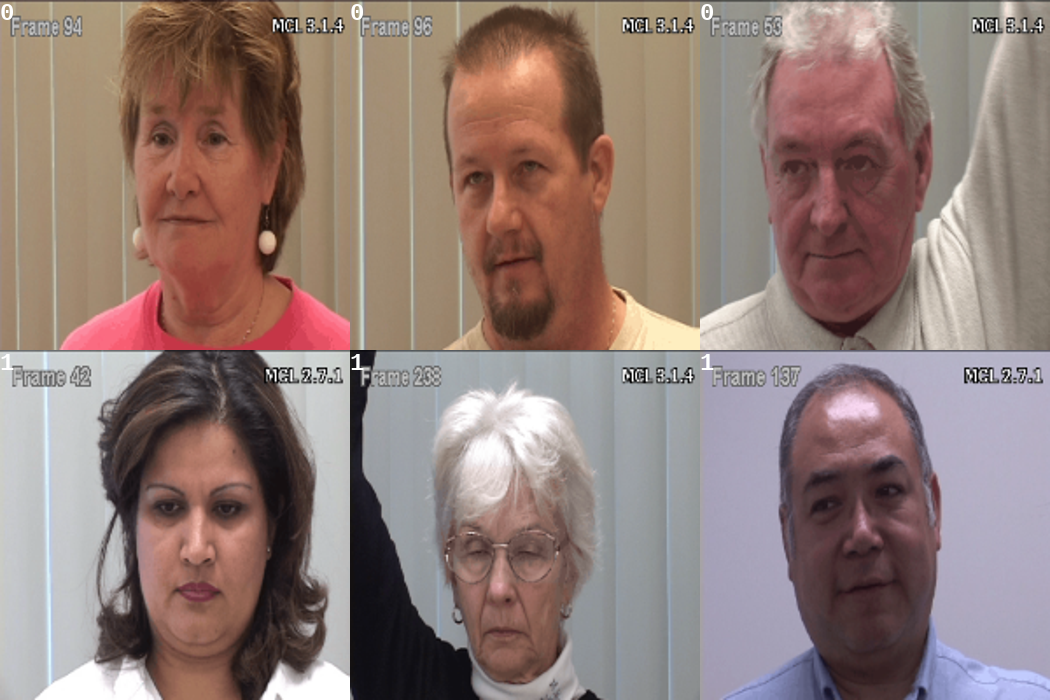

In [69]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [70]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/preprocessor_config.json
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



If we print a feature extractor, we can see its configuration.

In [71]:
feature_extractor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [73]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [74]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.2314, -0.2314, -0.2235,  ..., -0.2706, -0.2706, -0.2784],
          [ 0.3098,  0.3098,  0.3176,  ...,  0.2471,  0.2392,  0.2235],
          [ 0.4118,  0.4118,  0.4196,  ...,  0.3412,  0.3333,  0.3098],
          ...,
          [ 0.2157,  0.2157,  0.2078,  ...,  0.1765,  0.1373,  0.1294],
          [ 0.2000,  0.2000,  0.2000,  ...,  0.1451,  0.1294,  0.1294],
          [ 0.1843,  0.2000,  0.2078,  ...,  0.1294,  0.1294,  0.1294]],

         [[-0.1922, -0.1922, -0.1843,  ..., -0.2392, -0.2392, -0.2471],
          [ 0.3490,  0.3490,  0.3569,  ...,  0.2863,  0.2863,  0.2627],
          [ 0.4510,  0.4588,  0.4588,  ...,  0.3882,  0.3804,  0.3725],
          ...,
          [ 0.2314,  0.2392,  0.2392,  ...,  0.1608,  0.1608,  0.1608],
          [ 0.2235,  0.2314,  0.2314,  ...,  0.1529,  0.1529,  0.1529],
          [ 0.2078,  0.2235,  0.2314,  ...,  0.1529,  0.1529,  0.1529]],

         [[-0.1922, -0.1922, -0.1843,  ..., -0.2392, -0.2392, -0.2392],
          [ 0

In [75]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

We can directly apply this to our dataset using `ds.with_transform(transform)`.

In [76]:
prepared_ds = ds.with_transform(transform)

Now, whenever we get an example from the dataset, our transform will be 
applied in real time (on both samples and slices, as shown below)

In [77]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.2314, -0.2314, -0.2235,  ..., -0.2706, -0.2706, -0.2784],
          [ 0.3098,  0.3098,  0.3176,  ...,  0.2471,  0.2392,  0.2235],
          [ 0.4118,  0.4118,  0.4196,  ...,  0.3412,  0.3333,  0.3098],
          ...,
          [ 0.2157,  0.2157,  0.2078,  ...,  0.1765,  0.1373,  0.1294],
          [ 0.2000,  0.2000,  0.2000,  ...,  0.1451,  0.1294,  0.1294],
          [ 0.1843,  0.2000,  0.2078,  ...,  0.1294,  0.1294,  0.1294]],

         [[-0.1922, -0.1922, -0.1843,  ..., -0.2392, -0.2392, -0.2471],
          [ 0.3490,  0.3490,  0.3569,  ...,  0.2863,  0.2863,  0.2627],
          [ 0.4510,  0.4588,  0.4588,  ...,  0.3882,  0.3804,  0.3725],
          ...,
          [ 0.2314,  0.2392,  0.2392,  ...,  0.1608,  0.1608,  0.1608],
          [ 0.2235,  0.2314,  0.2314,  ...,  0.1529,  0.1529,  0.1529],
          [ 0.2078,  0.2235,  0.2314,  ...,  0.1529,  0.1529,  0.1529]],

         [[-0.1922, -0.1922, -0.1843,  ..., -0.2392, -0.2392, -0.2392],
          [ 0

# Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [78]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [79]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [80]:
labels = ds['train'].features['labels']

In [81]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "0",
    "1": "1"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "0": "0",
    "1": "1"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.25.1"
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c1

We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [82]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

PyTorch: setting up devices


Now, all instances can be passed to Trainer and we are ready to start training!



In [86]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["val"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [87]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** Running training *****
  Num examples = 2000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 500
  Number of trainable parameters = 85800194


Step,Training Loss,Validation Loss,Accuracy
100,0.546200,0.471301,0.780000
200,0.425300,0.446818,0.815000
300,0.233700,0.320624,0.877500
400,0.153000,0.299192,0.890000
500,0.125200,0.251847,0.905000


***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-100
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-100/config.json
Model weights saved in ./vit-base-beans-demo-v5/checkpoint-100/pytorch_model.bin
Image processor saved in ./vit-base-beans-demo-v5/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-200
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-200/config.json
Model weights saved in ./vit-base-beans-demo-v5/checkpoint-200/pytorch_model.bin
Image processor saved in ./vit-base-beans-demo-v5/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-300
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-300/config.json
Model weights saved in ./

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 577360314GF
  train_loss               =      0.3537
  train_runtime            =  0:03:13.24
  train_samples_per_second =      41.397
  train_steps_per_second   =       2.587


In [89]:
metrics = trainer.evaluate(prepared_ds['val'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 400
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.905
  eval_loss               =     0.2518
  eval_runtime            = 0:00:03.99
  eval_samples_per_second =    100.164
  eval_steps_per_second   =      12.52
